## 1. Load and transform the dataset

In [1]:
# Import libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Set the style for the visualizations in the notebook
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette('icefire')

In [2]:
# Load the dataset 
df = pd.read_csv('mma_mart.csv')

In [3]:
# Create a dataset containing unique product IDs on each row with an aggregated count of the number of times the product was ordered
products_df = pd.DataFrame(df.groupby('product_id')[['product_name','department','aisle']].value_counts())

In [4]:
# View the head of the dataset 
products_df.head()

,,,,0
product_id,product_name,department,aisle,
1,Chocolate Sandwich Cookies,snacks,cookies cakes,60
2,All-Seasons Salt,pantry,spices seasonings,2
3,Robust Golden Unsweetened Oolong Tea,beverages,tea,4
4,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,frozen,frozen meals,9
8,Cut Russet Potatoes Steam N' Mash,frozen,frozen produce,2


In [5]:
# Reset the index of the products dataframe 
products_df = products_df.reset_index()

In [6]:
# Rename column '0' to 'Number of Order'
products_df = products_df.rename(columns={0: 'num_order'})

In [7]:
# Check the first 5 rows of the dataframe again to view the changes
products_df.head()

,product_id,product_name,department,aisle,num_order
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes,60
1,2,All-Seasons Salt,pantry,spices seasonings,2
2,3,Robust Golden Unsweetened Oolong Tea,beverages,tea,4
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals,9
4,8,Cut Russet Potatoes Steam N' Mash,frozen,frozen produce,2


## 2. Find the stem word associate with each product name

#### Find keywords that are unique to each department

In [8]:
# Use Scikit-Learn's vectorizer to transform the product names into a sparse matrix for occuring frequencies analysis
# Import Scikit-Learn's Count Vectorizer 
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
# Create a dataframe storing list of unique product names for each department
dept_products = pd.DataFrame(products_df.groupby('department')['product_name'].unique())

In [10]:
# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at least 5% of the dataset
# Set an n-gram value of 1 to extract 1 word in a product name 
bagofwords = CountVectorizer(lowercase=True, min_df = 0.05, ngram_range=(1,1), stop_words='english')

In [11]:
# Create a dictionary to store the outputs of the loop
dept_high_freq_terms = {}

# Looping through each row in the dataframe containing a list of product names in each aisle
for i, name in enumerate(dept_products.index.values):
    # Retrieve the product names
    product_names = dept_products.iloc[i].values[0] 
    # Fit the product names to the count vectorizer
    bagofwords.fit(product_names)
    # Retrieve a list of frequently occuring terms within the list of product names 
    freq_terms = bagofwords.get_feature_names_out()
    # Add the frequently occuring terms to a dictionary with the aisle name as a key and the list of as the key's values 
    dept_high_freq_terms[name] = freq_terms

#### Find the keywords that are unique to each aisle

In [12]:
# Create a dataframe storing list of unique product names for each aisle 
aisle_products = pd.DataFrame(products_df.groupby('aisle')['product_name'].unique())

In [13]:
# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at least 5% of the dataset
# Set an n-gram value of 1 to extract 1 word in a product name 
bagofwords = CountVectorizer(lowercase=True, min_df = 0.05, ngram_range=(1,1), stop_words='english')

In [14]:
# Create a dictionary to store the outputs of the loop
aisle_high_freq_terms = {}

# Looping through each row in the dataframe containing a list of product names in each aisle
for i, name in enumerate(aisle_products.index.values):
    # Retrieve the product names
    product_names = aisle_products.iloc[i].values[0] 
    # Fit the product names to the count vectorizer
    bagofwords.fit(product_names)
    # Retrieve a list of frequently occuring terms within the list of product names 
    freq_terms = bagofwords.get_feature_names_out()
    # Add the frequently occuring terms to a dictionary with the aisle name as a key and the list of as the key's values 
    aisle_high_freq_terms[name] = freq_terms

#### Use stem words to avoid double counting similar product names

In [15]:
# Import NLTK libraries 
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Instantiate PorterStemmer 
ps = PorterStemmer()

In [16]:
# Create a dictionary with a list of stem words for each word in the product name 
all_stems = []
name_stems = {}
for product in list(products_df['product_name'].values):
    words = word_tokenize(product)
    stem_list = []
    for w in words:
        stem = ps.stem(w)
        all_stems.append(stem)
        stem_list.append(stem)
    name_stems[product] = stem_list

In [17]:
# Instantiate the count vectorizer 
# Set the parameters to convert all characters into lower case letters before tokenizing 
# Only include words with an occuring frequency of at most 10% of the dataset
# Set an n-gram value of 1 to extract 1 word in a product name 
bagofwords = CountVectorizer(lowercase=True, min_df = 0.0001, ngram_range=(1,1), stop_words='english').fit(all_stems)

# Fit and transform the product names by using the vectorizer 
transform = bagofwords.transform(all_stems)

In [18]:
# Create a dataframe to store the count vectorizer outputs 
stems_cv = pd.DataFrame({'word_stem': bagofwords.get_feature_names_out(), 'frequency': transform.toarray().sum(axis=0)})

In [19]:
# Sort the frequency count in descending order 
stems_cv_plot = stems_cv.sort_values(by='frequency', ascending=False)[:20]

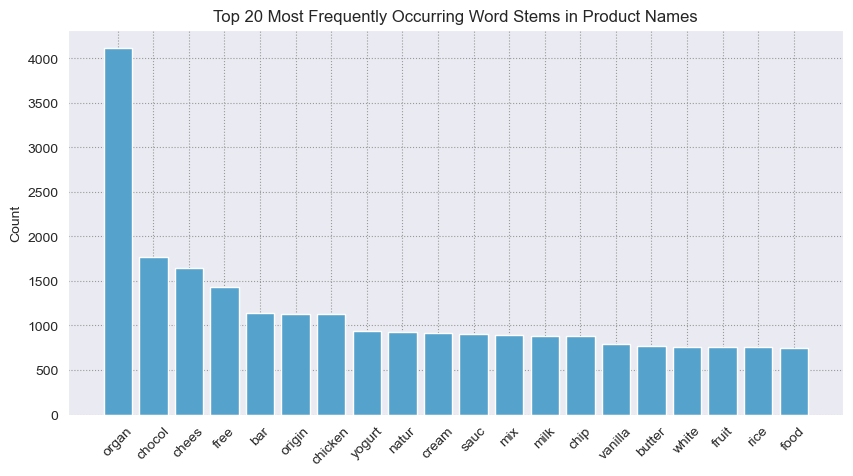

In [20]:
# Plot a bar chart to show the product names with the highest occurances 
plt.figure(figsize=(10,5))
plt.bar(stems_cv_plot['word_stem'], stems_cv_plot['frequency'])
plt.title(f"Top {stems_cv_plot.shape[0]} Most Frequently Occurring Word Stems in Product Names")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [21]:
# Find the word stem for list of ignored words 
ignore_word = ['original', 'organic', 'gluten', 'free', 'food', 'foods', 'fruit', 'size', 'stage', 'super']
ignore_stems = [ps.stem(w) for w in ignore_word]

In [22]:
# Converting the list of keywords in each department into word stems 
dept_stems = {}
for department in list(dept_high_freq_terms.keys()):
    all_stems = []
    for terms in list(dept_high_freq_terms[department]):
        stem = ps.stem(terms)
        if stem not in ignore_stems:
            all_stems.append(stem)
    dept_stems[department] = all_stems

In [23]:
# Converting the list of keywords in each aisle into word stems 
aisle_stems = {}
for aisle in list(aisle_high_freq_terms.keys()):
    all_stems = []
    for terms in list(aisle_high_freq_terms[aisle]):
        stem = ps.stem(terms)
        if stem not in ignore_stems:
            all_stems.append(stem)
    aisle_stems[aisle] = all_stems

In [24]:
# Find the most relevant stem word associate with each product 
product_best_stem = {}

for i in range(products_df.shape[0]):
    product_name = products_df['product_name'].iloc[i]
    stem_list = name_stems[product_name]
    max_score = 0
    best_stem = ''    
    for item in stem_list:
        if item in dept_stems[products_df['department'].iloc[i]]:
            best_stem = item
        elif item in aisle_stems[products_df['aisle'].iloc[i]]:
            best_stem = item
        if item in list(stems_cv['word_stem'].values):
            if (best_stem == '') and (item not in ignore_stems):
                score = stems_cv[stems_cv['word_stem'] == item]['frequency'].values[0]
                if score > max_score:
                    max_score = score
                    best_stem = item
    
    product_best_stem[product_name] = best_stem

In [25]:
# Assign the category stem word to the products 
stems = []
for i in range(products_df.shape[0]):
    stems.append(product_best_stem[products_df['product_name'].iloc[i]])

products_df['stem_group'] = stems

In [26]:
# Count number of unique stem groups 
products_df['stem_group'].nunique()

1149

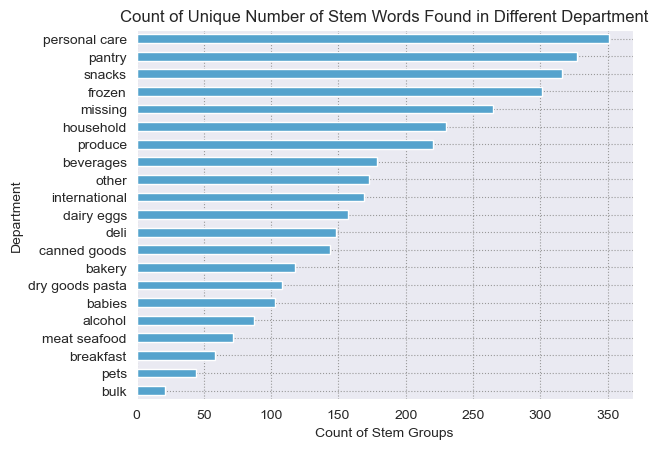

In [27]:
# Plot chart to show the count of stem group in each department 
products_df.groupby('department')['stem_group'].nunique().sort_values().plot(kind='barh')
plt.title('Count of Unique Number of Stem Words Found in Different Department')
plt.ylabel('Department')
plt.xlabel('Count of Stem Groups')
plt.show()

## 3. Build a function to match any requested products to availabel products in the Instabsket aisle

### 3.1 Using a 'for' loop to identify all possible substitutes for a list of 1,000 selected products from the Instabasket aisle 

The loop below will loop through each product name in a list of 1,000 selected products for the Instabasket aisle to find the previously identified stem word associated with the product name listed in the 'products_df' dataframe. Assuming that only products from the same department can be each other's substitutes, a product's substitute can be other products within the same department with the same stem word. 

Note: the csv file containing a list of 1,000 items must be correctly uploaded with a column specificly named 'product_name' which have 1,000 rows where each row is a unique product name. 

In [89]:
# Load a list of 1000 chosen products 

instabasket_products = pd.read_csv("instabasket_recommendations.csv")

In [90]:
# View the head of the dataframe to ensure that the dataframe contain one column named 'product_name'
instabasket_products.head()

,product_name
0,Organic Whole Milk
1,Organic Half & Half
2,Half & Half
3,Organic Whole String Cheese
4,Organic Unsweetened Almond Milk


In [91]:
# For loop to retrieve a list of possible substitutes, including items from the instabasket aisle, for each product 
substitutes = []
sub_count = []
for i in range(instabasket_products.shape[0]):
    # Find the stem word associate with the product 
    stem = products_df[products_df['product_name'] == instabasket_products['product_name'].iloc[i]]['stem_group'].values[0]
    # Find the department that the product belong to
    department = products_df[products_df['product_name'] == instabasket_products['product_name'].iloc[i]]['department'].values[0]
    # Gather a list of products that the selected item can substitute for 
    matches = products_df[(products_df['stem_group'] == stem) & (products_df['department'] == department)]['product_name'].values
    # Convert the array into a list 
    matches = list(matches)
    # Remove the product name from the list 
    matches.remove(instabasket_products['product_name'].iloc[i])
    # Add the list of substitutes to the empty list 
    substitutes.append(matches)
    sub_count.append(len(matches))
    
# Add the substitute list to the list of Instabasket products 
instabasket_products['substitutes'] = substitutes
instabasket_products['substitutes_num'] = sub_count

In [92]:
# Use a nested loop to remove substitutes that belong to the Instabasket aisle from the list of substitutes

# Create an empty list to store the outputs 
substitutes_outside_instabasket = []
sub_out_count = []
# Looping through each list in the substitutes column by using the row index  
for i in range(instabasket_products.shape[0]):
    sub_list = []
    for item in instabasket_products['substitutes'].iloc[i]:
        if item not in list(instabasket_products['product_name'].values):
            sub_list.append(item)
    substitutes_outside_instabasket.append(sub_list)
    sub_out_count.append(len(sub_list))

In [93]:
# Add the list of substitute items that are not in the Instabasket aisle to the dataframe 
instabasket_products['out_of_aisle_substitutes'] = substitutes_outside_instabasket
instabasket_products['out_of_aisle_substitutes_num'] = sub_out_count

In [94]:
# View the portion of the dataframe with the product names and their out-of-aisle substitutes 
instabasket_products[['product_name', 'out_of_aisle_substitutes']].head()

,product_name,out_of_aisle_substitutes
0,Organic Whole Milk,[Organic Lowfat Pomegranate Acai Kefir Probiot...
1,Organic Half & Half,"[Dairy Pure Fresh Half & Half, Rich & Creamy F..."
2,Half & Half,"[Dairy Pure Fresh Half & Half, Rich & Creamy F..."
3,Organic Whole String Cheese,"[2% Yellow American Cheese, Grade A Pasteurize..."
4,Organic Unsweetened Almond Milk,[Organic Lowfat Pomegranate Acai Kefir Probiot...


After retrieving the list of substitutes, we can find the top 10 Instabasket aisle products with the highest number of substitutes. 

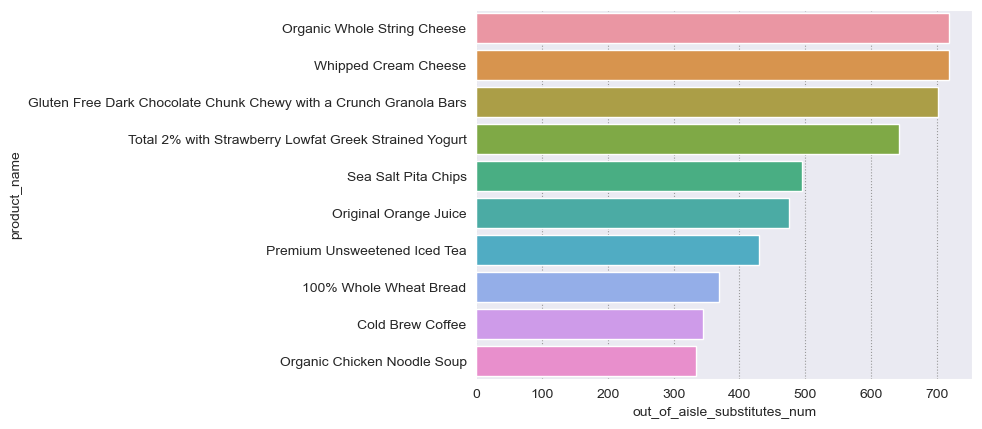

In [84]:
# Find top 10 Instabasket aisle products with highest number of substitutes (not including in-aisle items)
top_10 = instabasket_products.sort_values(by='out_of_aisle_substitutes_num', ascending=False)[:10]
sns.barplot(data=top_10, y='product_name', x='out_of_aisle_substitutes_num')
plt.show()

The loop below will calculate the total number of items outside of the Instabasket aisle that the list of 1,000 selected items in the Instabasket aisle can substitute for. 

In [95]:
# Find the total number of substitutes associate with each item in the Instabasket aisle 
# Create an empty list to store the outputs 
sub_list = []
# Looping through each list in the substitutes column by using the row index  
for i in range(instabasket_products.shape[0]):
    for item in instabasket_products['out_of_aisle_substitutes'].iloc[i]:
        if item not in sub_list:
            sub_list.append(item)
print(len(sub_list))

3983
